In [ ]:
import functools
import os
import numpy as np
import time
from absl import app
from absl import flags
from absl import logging

import mnist_model  # ADDED
# REMOVED from experimental.mimo import cifar_model  # local file import
import robustness_metrics as rm
import tensorflow as tf
import tensorflow_datasets as tfds
import uncertainty_baselines as ub
import baselines.utils_new as utils  # ADDED this!
# from uncertainty_baselines.baselines.cifar import utils
import uncertainty_metrics as um


import numpy as np
import os
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import entropy
import seaborn as sns

In [ ]:
ensemble_size = 1
output_dir="/Users/benna/Desktop/DLA/OOD-detection-using-MIMO/MNIST_NN/M"+str(ensemble_size)+"/"

image_shape=[28,28,1]
width_multiplier=2 
num_classes=10

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)
checkpoint.restore(latest_checkpoint)



In [ ]:
def load_not_mnist(im_root,batch_size):
    dirs = os.listdir(im_root)
    label_dict = defaultdict()

    filenames=[]
    labels=[]
    for idx, dr in enumerate(dirs):
        # print(dr)
        label_dict[idx] = dr
        ims = os.listdir(os.path.join(im_root, dr))
        random.shuffle(ims)
        for im in (ims):
            if im=="RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png" or im== "Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png":
                continue
            # # 
            # image_string = tf.io.read_file(os.path.join(im_root, dr, im))
            # try:
            #     tf.io.decode_image(image_string)
            # except:
            #     print(im)
            #     continue
            else:
                filenames.append(os.path.join(im_root, dr, im))
                labels.append(idx)
        
    filenames = tf.constant(filenames)
    labels = tf.constant(labels) 
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

    def _parse_function(filename, label):

        normalize=True
        dtype = tf.float32

        image_string = tf.io.read_file(filename)
        image = tf.io.decode_image(image_string, dtype=dtype)

        # image = tf.image.convert_image_dtype(image_decoded, dtype)
        if normalize:
            # We use the convention of mean = np.mean(train_images, axis=(0,1,2))
            # and std = np.std(train_images, axis=(0,1,2)).
            mean = tf.constant([0.1307], dtype=dtype)
            std = tf.constant([0.3081], dtype=dtype)
            # Previously, std = np.mean(np.std(train_images, axis=(1, 2)), axis=0)
            # which gave std = tf.constant([0.2023, 0.1994, 0.2010], dtype=dtype).
            # However, we change convention to use the std over the entire training
            # set instead.
            image = (image - mean) / std
        label = tf.cast(label, dtype)
        return image, label

    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


In [ ]:
### LOAD DATASETS
test_datasets={}
test_batch_size=500
N_mnist = 10000
N_NOTmnist = 18710

dataset_builder_class = ub.datasets.MnistDataset
clean_test_dataset_builder = dataset_builder_class(split=tfds.Split.TEST)

clean_test_dataset = clean_test_dataset_builder.load(batch_size=test_batch_size)
test_datasets = {'clean': clean_test_dataset,}

load_c_dataset = utils.load_mnist_c

corruption_types, max_intensity = utils.load_corrupted_test_info("mnist")
for corruption in corruption_types[:]:
    for intensity in range(1, max_intensity + 1):
        dataset = load_c_dataset(
            corruption_name=corruption,
            corruption_intensity=intensity,
            batch_size=test_batch_size,
            use_bfloat16=False)

        test_datasets['{0}_{1}'.format(corruption, intensity)] = (
            # strategy.experimental_distribute_dataset(dataset))
            dataset)

not_minst_root = '/Users/benna/Desktop/DLA/dataset/notMNIST_small'
not_mnist_dataset= load_not_mnist(not_minst_root,test_batch_size)
test_datasets['notMNIST'] =  not_mnist_dataset

# acc=tf.keras.metrics.SparseCategoricalAccuracy()

#@tf.function
def test_step(test_iterator, dataset_name):
    if  dataset_name == 'clean':
        images, label = next(test_iterator).values()
    else:
        images, label = next(test_iterator)

    images = tf.tile(tf.expand_dims(images, 1), [1, ensemble_size, 1, 1, 1])
    logits = model(images, training=False)
    probs = tf.nn.softmax(logits)
    # print(probs.shape)
    probs = tf.math.reduce_mean(probs, axis=1)  # marginalize
    # acc.update_state(label, probs)
    # print(probs.shape)
    entr=entropy(probs,base=10,axis=1)
    # print(entr)
    # plt.hist(entr, histtype="step", align="left",bins=np.arange(-0.5,2.5,0.5))
    return entr


### TEST

ensemble_size = 1
output_dir="/Users/benna/Desktop/DLA/OOD-detection-using-MIMO/MNIST_NN/M"+str(ensemble_size)+"/"

image_shape=[28,28,1]
width_multiplier=2 
num_classes=10

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)
checkpoint.restore(latest_checkpoint)

Entropies=defaultdict()

datasets_to_evaluate = test_datasets

for dataset_name, test_dataset in datasets_to_evaluate.items():
    entropy_test=[]
    test_iterator = iter(test_dataset)
    print('Testing on dataset %s', dataset_name)

    if dataset_name == "notMNIST":
        N_images = N_NOTmnist
    else:
        N_images = N_mnist
    entropy_test=[]
    for _ in range(N_images//test_batch_size):
        entropy_test.append(test_step(test_iterator, dataset_name))
    entropy_test = np.reshape(entropy_test, (-1,1))
    Entropies['M{0}_{1}'.format(ensemble_size, dataset_name)] = entropy_test

In [ ]:
ensemble_size = 2
output_dir="/Users/benna/Desktop/DLA/OOD-detection-using-MIMO/MNIST_NN/M"+str(ensemble_size)+"/"

image_shape=[28,28,1]
width_multiplier=2 
num_classes=10

model = mnist_model.wide_resnet(
    input_shape=[ensemble_size] +
                image_shape,
    depth=28,
    width_multiplier=width_multiplier,
    num_classes=num_classes,
    ensemble_size=ensemble_size)

optimizer = tf.keras.optimizers.SGD( momentum=0.9, nesterov=True)
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
latest_checkpoint = tf.train.latest_checkpoint(output_dir)
checkpoint.restore(latest_checkpoint)

for dataset_name, test_dataset in datasets_to_evaluate.items():
    entropy_test=[]
    test_iterator = iter(test_dataset)
    print('Testing on dataset %s', dataset_name)

    if dataset_name == "notMNIST":
        N_images = N_NOTmnist
    else:
        N_images = N_mnist
    entropy_test=[]
    for _ in range(N_images//test_batch_size):
        entropy_test.append(test_step(test_iterator, dataset_name))
    entropy_test = np.reshape(entropy_test, (-1,1))
    Entropies['M{0}_{1}'.format(ensemble_size, dataset_name)] = entropy_test

In [ ]:
for dataset_name, entr in Entropies.items():
    sns.distplot(entr, hist=False,
                kde=True, 
            bins=np.arange(0,2,1),
            color = 'red', 
            kde_kws={'linewidth': 1 })

In [ ]:
sns.distplot(np.reshape(entropy_test, (-1,1)), hist=False,
                kde=True, 
            bins=np.arange(0,2,1),
            color = 'red', 
            kde_kws={'linewidth': 1 })

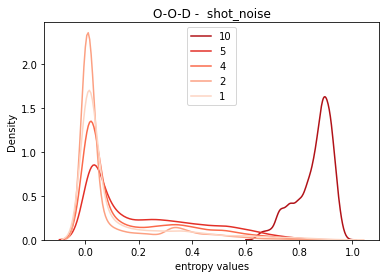

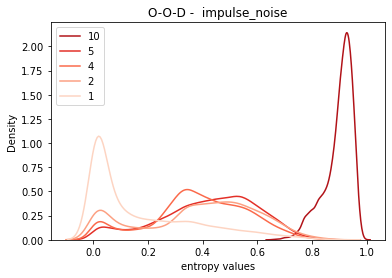

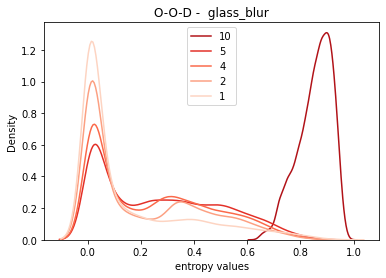

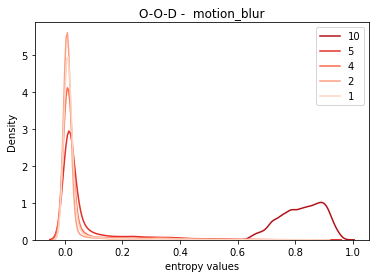

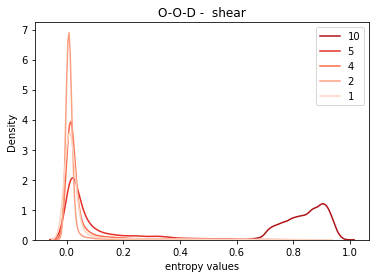

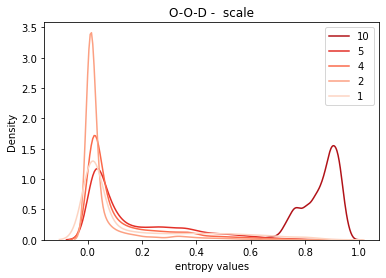

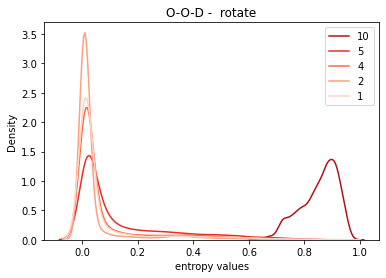

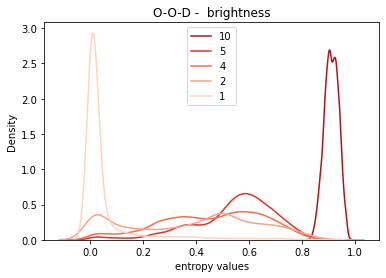

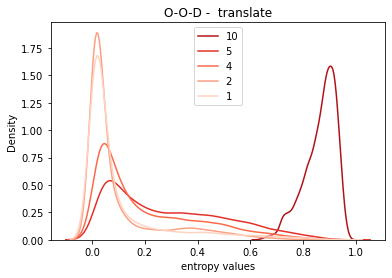

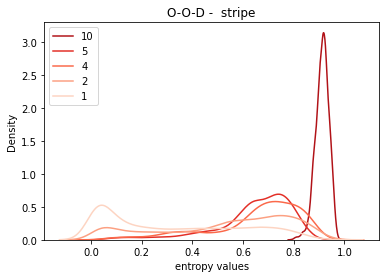

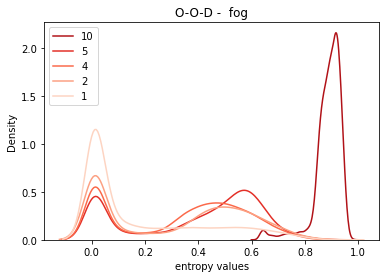

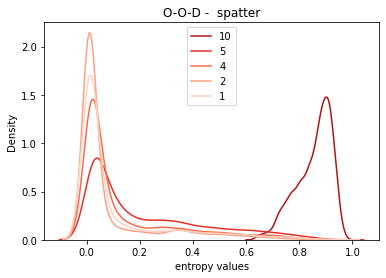

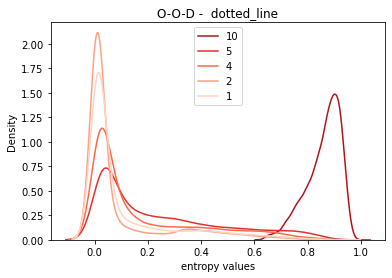

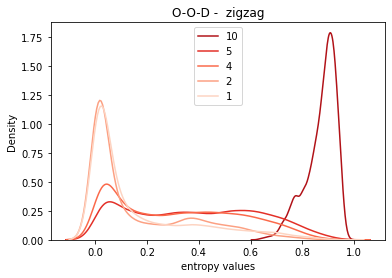

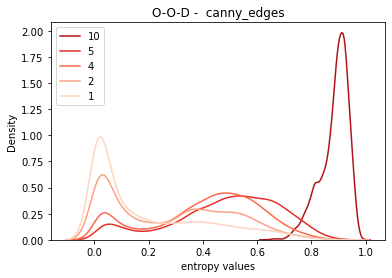

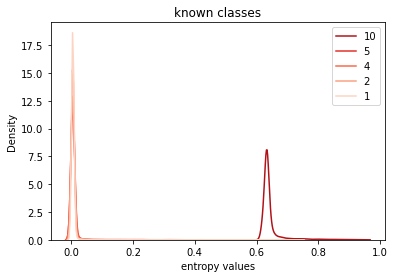

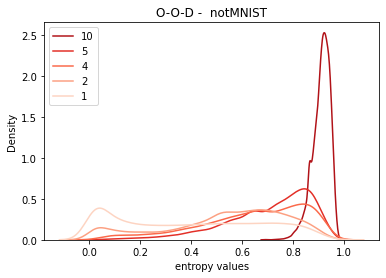

In [145]:
import pickle as pkl
import numpy as np

M=[1, 2, 4, 5, 10]
N_mnist = 10000
N_NOTmnist = 18500


corruption_types, max_intensity = utils.load_corrupted_test_info("mnist")
corruption_types = [c+'_'+str(max_intensity)for c in corruption_types]
corruption_types.append("clean")
# corruption_types.extend(["notMNIST", "clean"])
# corruption_types
E={}
for c in corruption_types:
    E[c]= np.zeros((len(M),N_mnist))
E["notMNIST"] = np.zeros((len(M),N_NOTmnist))

for i,ensemble_size in enumerate(M):#np.append(np.arange (1,7), 10):
    Entropies = pkl.load( open( "Entropies_M"+str(ensemble_size)+".pkl", "rb" ) )
    for dataset_name, entr in Entropies.items():
        # print(dataset_name)
        name=dataset_name[4:] if ensemble_size ==10 else  dataset_name[3:]
        E[name][i]=entr.flatten()
        # print(dataset_name[3:])
        # print(name)
for dataset_name, entr in E.items():
    if dataset_name!= "identity_1":
        name = dataset_name if dataset_name== "clean" or dataset_name == 'notMNIST' else dataset_name[:-2]
        title= "O-O-D - " + name if name != "clean" else "known classes"
        plt.figure()
        sns.kdeplot(data=E[dataset_name].T, palette="Reds")
        plt.legend(np.flip(M))
        plt.xlabel("entropy values")
        plt.title(title)
        plt.plot()
        plt.savefig(title+'.png')
    

#         if dataset_name == 'M'+str(ensemble_size)+'':
# for i in range(len(M)):
    # sns.kdeplot(data=E["clean"][i])
    # (E["clean"][i], hist=False, kde=True, bins=np.arange(0,2,1), color = 'red', kde_kws={'linewidth': 1 })
# sns.kdeplot(data=E["clean"][:2,:100])


# plt.plot()



Text(0.5, 0, 'entropy values')

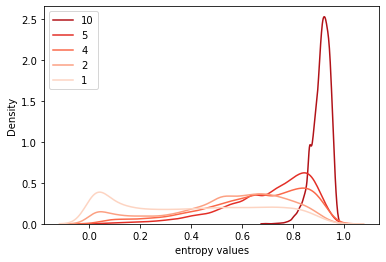

In [125]:

# sns.color_palette("Reds")[:7]


((2, 5), (7, 10000))

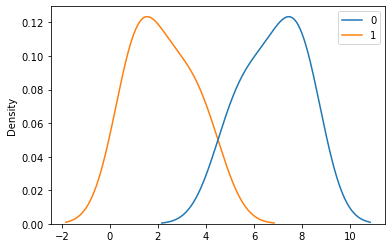

In [73]:
sns.kdeplot(data=[[5,6,7,8,8],[1,1,2,3,4]])
np.shape([[5,6,7,8,8],[1,1,2,3,4]]), np.shape(E["clean"])